# Blog Post Series - AI Fairness 360: Mitigating Bias in Machine Learning Models

## Part 1: **Creating Dataset Objects in AI Fairness 360 and Exploring Fairness Metrics**


### Introduction to AI Fairness

Artificial Intelligence (AI) has revolutionized various sectors, from healthcare to finance, by providing powerful tools to analyze data and make informed decisions. However, as these AI systems become more integrated into society, ensuring that they operate fairly and without bias becomes increasingly important. Bias in AI can lead to unfair outcomes, which can have significant social and ethical implications.

IBMâ€™s AI Fairness 360 (AIF360) toolkit helps developers detect and mitigate bias in machine learning models. In this series, we will explore AIF360, its importance, and how to start using it to create more equitable AI systems.





### Learning Objectives

By the end of this blog post, you will be able to:
- Understand the concept of bias in AI and its implications.
- Learn how to use AI Fairness 360 (AIF360) to detect bias.
- Create dataset objects using AIF360's `BinaryLabelDataset` class.
- Utilize fairness metrics to evaluate bias in datasets and models.



### Prerequisites

Before we begin, ensure you have the following installed:
- Python 3.x
- Pandas
- AI Fairness 360





### Understanding Bias in AI

Bias in AI can stem from various sources, broadly categorized into:

1.	Data Bias: When the training data is not representative of the real-world population.
2.	Algorithmic Bias: When algorithms inadvertently amplify existing biases in the data.
3.	Societal Bias: Reflecting broader societal prejudices and inequalities.

Biased AI systems can lead to discriminatory practices in areas such as hiring, lending, law enforcement, and healthcare. For example, a biased healthcare algorithm might disproportionately favor certain demographic groups, leading to disparities in care. 


Real-world examples of biased AI systems highlight the urgency of addressing this issue. For instance, a study found that a widely used healthcare algorithm disproportionately favored white patients over black patients when determining eligibility for certain health programs, leading to disparities in care.



### Introduction to AI Fairness 360

AI Fairness 360 (AIF360) is an open-source toolkit developed by IBM to address the challenge of bias in machine learning models. The toolkit provides a comprehensive suite of metrics to test for biases and algorithms to mitigate them.

**Toolkit Overview**
AIF360 includes:

- **Datasets**: A variety of datasets commonly used in fairness research, such as the Adult Income dataset and the COMPAS dataset.
- **Metrics**: A collection of fairness metrics to evaluate bias in datasets and models, including disparate impact, statistical parity, and equal opportunity difference.
- **Algorithms**: Several bias mitigation algorithms, such as reweighing, prejudice remover, and adversarial debiasing.

**Installation**
To get started with AI Fairness 360, you first need to install the toolkit. You can install it using pip:



You can install the base components AI Fairness 360 using pip:
```bash
pip install aif360
```

To install all optional dependencies use:
```bash
pip install 'aif360[all]'
```

For more information, see https://aif360.readthedocs.io/en/latest/Getting%20Started.html#installation.


In the following sections, we will walk through a practical example using AIF360 to detect and mitigate bias in a machine learning model.



---

### Practical Example: Detecting and Mitigating Bias




In this example, we will use the Recidivism for Offenders Released from Prison dataset [directly from the IOWA Open Data Portal](https://data.iowa.gov/Correctional-System/Iowa-Prison-Recidivism-Status/akzb-ddk8/about_data), which provides information on individuals released from prison and their likelihood of reoffending. This dataset is suitable for studying fairness as it contains various demographic features that can be analyzed for bias.


**Dataset Construction**
To use AIFairness 360, the data must be converted into a proprietary AIF360 dataset object. The requirements for the Dataset objects are as follows:
1. Categorical Features encoded numerically (Not One hot encoded).
2. No null values.
3. Defined **Protected attributes** (e.g., Race, Sex).
    - **Definition**: Attributes that refer to characteristics of individuals that are legally protected against discrimination. These can include race, gender, age, religion, disability status, and other similar attributes.
4. For each protected attribute, defined Privileged groups (e.g. Male or White) and Unprivileged Groups (e.g. Female, Non-white). 
    - **Privileged Groups**: Subsets of individuals within a dataset that have historically been favored or have had advantages in societal contexts based on certain protected attributes.
    - **Unprivileged Groups**: Subsets of individuals within a dataset that have historically been disadvantaged or have faced discrimination based on certain protected attributes.


### Introduction to AIF360 Datasets


In order to use AIF360, we must convert our DataFrames into one of two classes from AIF360: the `BinaryLabelDataset` and the `StandardDataset`.

In this blog post, we will focus on creating dataset objects using the `BinaryLabelDataset` class provided by AIF360. 

Additionally, we will begin to explore some key fairness metrics to understand how bias can be measured and addressed.



#### Loading the Dataset as DataFrame First


In [1]:

import pandas as pd
import numpy as np
pd.set_option("display.max_columns", 100)

# Load the data 
df = pd.read_csv("blog_post/data/Iowa_Prison_Recidivism_Status_20240724.csv", 
                 index_col=0, usecols=range(0, 23-7))   

## Quick Conversion of Dtypes for Clean Data
df = df.convert_dtypes(convert_string=False)

# Drop unnecessary columns
drop_cols = ['Supervising Unit','Supervision Start Date','Supervision End Date'] + [c for c in df.columns if 'Year' in c]
df = df.drop(columns=drop_cols)
df.info()
df.head()



<class 'pandas.core.frame.DataFrame'>
Index: 25244 entries, 20655350 to 20999813
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Race                         25244 non-null  object 
 1   Sex                          25241 non-null  object 
 2   Age                          25244 non-null  Int64  
 3   Supervision Type             25244 non-null  object 
 4   Months Supervised            25244 non-null  Int64  
 5   Supervision End Reason       25244 non-null  object 
 6   Supervision Offense Class    25244 non-null  object 
 7   Supervision Offense Type     25244 non-null  object 
 8   Supervision Offense Subtype  25244 non-null  object 
 9   Reincarcerated               25244 non-null  boolean
dtypes: Int64(2), boolean(1), object(7)
memory usage: 2.0+ MB


Race   Sex  Age Supervision Type  Months Supervised  \
Offender Number                                                         
20655350         White  Male   35           Prison                125   
18876932         Black  Male   30           Prison                 49   
2424146          White  Male   40           Prison                  8   
19088303         Black  Male   29     Work Release                  2   
20280797         White  Male   38           Prison                 11   

                              Supervision End Reason  \
Offender Number                                        
20655350         Discharged - Expiration of Sentence   
18876932                Released to Special Sentence   
2424146                               Parole Granted   
19088303                              Parole Granted   
20280797               Paroled w/Immediate Discharge   

                Supervision Offense Class Supervision Offense Type  \
Offender Number                                                      
20655350                         B Felony                  Violent   
18876932                         D Felony                    Other   
2424146            Aggravated Misdemeanor             Public Order   
19088303                         C Felony                     Drug   
20280797           Aggravated Misdemeanor                 Property   

                Supervision Offense Subtype  Reincarcerated  
Offender Number                                              
20655350                                Sex           False  
18876932                     Other Criminal           False  
2424146                  Other Public Order           False  
19088303                        Trafficking           False  
20280797                           Burglary           False


#### Encoding Protected Attributes Features as Integers

To work with AIF360, we need to encode the categorical features numerically. In this example, we'll focus on the 'race' attribute as a protected attribute.


In [2]:
# Preview unique classes for protected attributes
df['Race'].unique(), df['Sex'].unique()

(array(['White', 'Black', 'Hispanic', 'Asian or Pacific Islander',
        'American Indian or Alaska Native', 'Unknown'], dtype=object),
 array(['Male', 'Female', nan], dtype=object))

Although there is no official statement regarding the compatibility of protected attribute columns with the metrics discussed in this post, the author experienced difficulties when working with multi-class protected attributes. Therefore, for now, we have converted the Race column into a binary column where 0 represents being White and 1 represents Non-White. 

In [3]:
# Encode the 'race' column as binary white or non-white.
race_map = {'White': 0, 'Black': 1, 'Hispanic': 1, 'Asian or Pacific Islander': 1,
            'American Indian or Alaska Native': 1, 'Unknown': 1, 'Other':1}
df['Race'] = df['Race'].map(race_map)

# Encode the "Sex" column
sex_map = {"Male": 0, "Female":1}
df['Sex'] = df['Sex'].map(sex_map)

df['Race'].unique(), df['Sex'].unique()

(array([0, 1]), array([ 0.,  1., nan]))

We will be using both string and integer labels for our groups throughout this example. Therefore, we will save the dictionary maps together for later.

In [4]:
## Saving the protcted attribute mapping dictionaries to a dict
protected_attribute_maps = {"Race":race_map,
                            "Sex":sex_map}

### Preprocessing for Dataset Object Creation

The AI Fairness 360 (AIF360) toolkit provides different dataset classes to handle various types of data structures and use cases. Two commonly used classes are `BinaryLabelDataset` and `StandardDataset`. 

Both classes require that:
- The protected attributes (i.e. Race and Sex) and target (Reincarcerated) must be encoded as integers.
- All features must be numerically encoded (One Hot Encoded categorical features, Boolean features as integers)
- No null values are present.

Therefore we will prepare the data as if we were preparing it for machine learning. However, we will not produce a train-test-split.

In [5]:
# Impute NaNs with most frequent value
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

# Enable pandas dataframe output
from sklearn import set_config
set_config(transform_output='pandas')


In [6]:

# Categorical Pipeline
cat_cols = df.select_dtypes(include='object').columns
cat_imputer = SimpleImputer(strategy='most_frequent')
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
cat_pipe = make_pipeline(cat_imputer, ohe)


# Numeric Pipeline
num_cols = df.select_dtypes(include='number').columns
num_imputer = SimpleImputer(strategy='mean')
num_pipe = make_pipeline(num_imputer)


# Convert Boolean Columns to Integers
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)


# Create the column Transformer
preprocessor = ColumnTransformer(transformers=[('cat', cat_pipe, cat_cols),
                                               ('num', num_pipe, num_cols)],
                                 remainder='passthrough',
                                 verbose_feature_names_out=False)

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Supervision Type', 'Supervision End Reason',
       'Supervision Offense Class', 'Supervision Offense Type',
       'Supervision Offense Subtype'],
      dtype='object')),
                                ('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 Index(['Race', 'Sex', 'Age', 'Months Supervised'], dtype='object'))],
                  verbose_feature_names_out=False)

In [7]:
# Fit and Transform the data
final_df = preprocessor.fit_transform(df)
final_df

Supervision Type_Prison  Supervision Type_Work Release  \
Offender Number                                                           
20655350                             1.0                            0.0   
18876932                             1.0                            0.0   
2424146                              1.0                            0.0   
19088303                             0.0                            1.0   
20280797                             1.0                            0.0   
...                                  ...                            ...   
20997251                             1.0                            0.0   
20997488                             0.0                            1.0   
20999039                             1.0                            0.0   
20999069                             0.0                            1.0   
20999813                             1.0                            0.0   

                 Supervision End Reason_Discharged - Expiration of Sentence  \
Offender Number                                                               
20655350                                                       1.0            
18876932                                                       0.0            
2424146                                                        0.0            
19088303                                                       0.0            
20280797                                                       0.0            
...                                                            ...            
20997251                                                       0.0            
20997488                                                       0.0            
20999039                                                       0.0            
20999069                                                       0.0            
20999813                                                       0.0            

                 Supervision End Reason_Parole Granted  \
Offender Number                                          
20655350                                           0.0   
18876932                                           0.0   
2424146                                            1.0   
19088303                                           1.0   
20280797                                           0.0   
...                                                ...   
20997251                                           0.0   
20997488                                           1.0   
20999039                                           1.0   
20999069                                           1.0   
20999813                                           0.0   

                 Supervision End Reason_Paroled to Detainer - INS  \
Offender Number                                                     
20655350                                                      0.0   
18876932                                                      0.0   
2424146                                                       0.0   
19088303                                                      0.0   
20280797                                                      0.0   
...                                                           ...   
20997251                                                      0.0   
20997488                                                      0.0   
20999039                                                      0.0   
20999069                                                      0.0   
20999813                                                      0.0   

                 Supervision End Reason_Paroled to Detainer - Iowa  \
Offender Number                                                      
20655350                                                       0.0   
18876932                                                       0.0   
2424146                                                        0.0   
19088303  

### Defining Protected Attributes and Privileged vs. Unprivileged Groups

Before we can convert our preprocessed data to a BinaryDataset, we need to take a moment to fully map the protected attributes and for each attribute, we must define privileged groups and unprivileged groups.

If you use one of the Built-In datasets, it comes with a data dictionary. If we construct a similar data dictionary, we can leverage example code from official AIF360 tutorials to convert our data_dict into the correctly formatted group variables.

#### Examining the Data Dict of the Tutorial Dataset

- Tutorial: Medical Expendature: https://github.com/Trusted-AI/AIF360/blob/main/examples/tutorial_medical_expenditure.ipynb
- See the notebook linked above for instructions on running this example locally. 
Note that we will only briefly analyze the contents of this tutorial example, so you can safely skip over these steps when working through this example on your own.

In [8]:
## Tutorial Code source:  https://github.com/Trusted-AI/AIF360/blob/main/examples/tutorial_medical_expenditure.ipynb

# Datasets
from aif360.datasets import MEPSDataset19
from aif360.datasets import MEPSDataset20
from aif360.datasets import MEPSDataset21

# dataset = MEPSDataset19()#.split([0.5, 0.8], shuffle=True)

(dataset_orig_panel19_train,
 dataset_orig_panel19_val,
 dataset_orig_panel19_test) = MEPSDataset19().split([0.5, 0.8], shuffle=True)

# Numeric index for sensitive/protected attribute
sens_ind = 0

# Name of the sensitive/protected attribute
sens_attr = dataset_orig_panel19_train.protected_attribute_names[sens_ind]

# List comp to create a list of dictionaries for unprivileged and privileged groups
unprivileged_groups = [{sens_attr: v} for v in
                       dataset_orig_panel19_train.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in
                     dataset_orig_panel19_train.privileged_protected_attributes[sens_ind]]

# Preview the group vars
print(f"{unprivileged_groups = }")
print(f"{privileged_groups = }")

unprivileged_groups = [{'RACE': 0.0}]
privileged_groups = [{'RACE': 1.0}]


Notice that the dataset objects already had information about the `protected_attribute_names` and the integer values for the encoded protected attributes (`privileged_protected_attributes` `unprivileged_protected_attributes` ).

The tutorial used a list comprehension to convert the arrays of group integer values into a list of dictionaries, with the `[{Protected Attribute Name:Integer Value}]`.


The tutorial then demonstrates instantiated a  BinaryLabelDatasetMetric with the dataset and the list of privileged group dictionaries.

In [9]:
# Fairnes metrics & Explainers
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.explainers import MetricTextExplainer


# Metrics for the tutorial dataset
metric_orig_panel19_train = BinaryLabelDatasetMetric(
        dataset_orig_panel19_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)


/opt/homebrew/Caskroom/miniforge/base/envs/fair-env/lib/python3.12/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


The tutorial then instanstiates a MetricTextExplainer to facilitate understanding of the metrics.  The first example metric, which will discuss more in-depth later, is Disparate Impact. 

In [10]:

# Explainer to describe the fairness metrics
explainer_orig_panel19_train = MetricTextExplainer(metric_orig_panel19_train)
# Displaying disparate_impact
print(explainer_orig_panel19_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.49744042633483765


Now, to begin analyzing the metrics of our Prisoner Recividism dataset, we will first want to declare the protected attributes, and privileged and unprivileged group numbers.

### Mimicking the Tutorial's Data  Dictionary

#### Extracting and Inspecting the Tutorial Data Dictionary 


If we convert one of the example datasets to a dataframe using the `.convert_to_dataframe()` method, we will get the dataframe, as well as a data dict that stores the information about the protected attributes and priviledge groups.

In [11]:
# Converting the example dataset to a dataframe and data dictionary 
example_df, example_data_dict = dataset_orig_panel19_train.convert_to_dataframe()
# display(example_df.head(3))

# Exploring the contents of the data dictionary
print("Data Dict Keys:")
[print(f"- {k}") for k in example_data_dict.keys()];

Data Dict Keys:
- feature_names
- label_names
- protected_attribute_names
- instance_names
- instance_weights
- privileged_protected_attributes
- unprivileged_protected_attributes


In [12]:
# Target label var stored in list of strings - Only 1 target column
example_data_dict['label_names']

['UTILIZATION']

In [13]:
# List of protected attribute column names
example_data_dict['protected_attribute_names']

['RACE']

For each protected attribute, the data dictionary has an array of the group values that are privileged (believed to have an unfair advantage) and unprivileged. 


In [14]:
# List of privileged values for each protected attribute
display(example_data_dict['privileged_protected_attributes'])

# List of unprivileged values for each protected attribute
display(example_data_dict['unprivileged_protected_attributes'])

[array([1.])]

[array([0.])]


> Take note that, in this example, we have only 1 protected attribute. 

For the privileged/unprivileged groups, we have a list, with 1 array for each of our protected attributes, but in this case we only have one so its a list of a single array.

#### Creating our own data_dictionary



Let's create a new data dictionary based on our Iowa Prisoner Recidivism dataset. In this dataset, we have more than 1 protected attribute, which increases the complexity of our code.

In [15]:
example_data_dict.keys()

dict_keys(['feature_names', 'label_names', 'protected_attribute_names', 'instance_names', 'instance_weights', 'privileged_protected_attributes', 'unprivileged_protected_attributes'])

Since all of the representations of the groups need to be converted to lists of integers, we will save our integer-group mapping dictionaries to a final dictionary under the key for the corresodning atribute.

We will also save a dictionary with a key for each protected attribute and the **names** of the privileged groups for each protected attribute.

In [16]:
## Saving the protcted attribute mapping dictionaries to a dict

# Commented Out: previously saved above
# protected_attribute_maps = {"Race":race_map,
#                             "Sex":sex_map}

print("- protected_attribute_maps:")
display(protected_attribute_maps)

# Manually defining the list of privileged group NAMES to a dict
prot_attrs_priv_group_names = {'Race':["White"],
                               "Sex":["Male"]}

print("- prot_attrs_priv_group_names:")
prot_attrs_priv_group_names

- protected_attribute_maps:


{'Race': {'White': 0,
  'Black': 1,
  'Hispanic': 1,
  'Asian or Pacific Islander': 1,
  'American Indian or Alaska Native': 1,
  'Unknown': 1,
  'Other': 1},
 'Sex': {'Male': 0, 'Female': 1}}

- prot_attrs_priv_group_names:


{'Race': ['White'], 'Sex': ['Male']}

Let's review the structure of the example data dictionary before we reproduce it for our prisoner recidivism data.

In [17]:
# Revieing the structure of 
example_data_dict.keys()

dict_keys(['feature_names', 'label_names', 'protected_attribute_names', 'instance_names', 'instance_weights', 'privileged_protected_attributes', 'unprivileged_protected_attributes'])

In [18]:
# Creating a data dictionary like the one used in AIF360's medical expenditure example
target = 'Reincarcerated'

# Saving the feature names as a list
feature_names = final_df.drop(columns=target).columns
protected_attributes_names = list(protected_attribute_maps.keys())

# Starting our own data dictionary
DATA_DICT = dict(feature_names=feature_names, # list of feature columns
                 label_names = [target], # list with just the target label column
                 protected_attributes_names = protected_attributes_names, # list of protected attribute columns
                 
                # Saving information about each row (not used )
                #  instance_names = final_df.index, # list of each row's name
                #  instance_weights = np.ones_like(final_df.index), # list of each row's weight (1.0 for now
                
                
                # List of arrays of privileged group numbers: will be filled in later
                privileged_protected_attributes = [], 
                # List of arrays of unprivileged group numers: Will be filled in later
                unprivileged_protected_attributes = [], 
)
                 
DATA_DICT.keys()


dict_keys(['feature_names', 'label_names', 'protected_attributes_names', 'privileged_protected_attributes', 'unprivileged_protected_attributes'])

### For Loop: Accounting for More than 1 Protected Attribute per Dataset

We will need to produce the group information for every protected attribute in the dataset. In this case, the proteted attributes are Race and Sex.
Before we construct a loop to handle both protected attributes, let's manually slice out the first attribute and figure out our workflow.

In [19]:
# Numeric index of current protected attribute
attr_idx = 0

# slice the name of the current protected attribute
attr_name = protected_attributes_names[attr_idx]

# Get the mapping for the current protected attribute
attr_map = protected_attribute_maps[attr_name]
attr_map

{'White': 0,
 'Black': 1,
 'Hispanic': 1,
 'Asian or Pacific Islander': 1,
 'American Indian or Alaska Native': 1,
 'Unknown': 1,
 'Other': 1}

In [20]:
# # Get the privileged group names for the current protected attribute
priv_group_names = prot_attrs_priv_group_names[attr_name]
priv_group_names

['White']

In [21]:
# Get the privileged values for the current protected attribute
privileged_group_nums = np.array([attr_map[pg] for pg in priv_group_names])
privileged_group_nums

array([0])

In [22]:
# Get the unprivileged values for the current protected attribute
unprivileged_group_nums = np.array([v for v in attr_map.values() if v not in privileged_group_nums])
unprivileged_group_nums

array([1, 1, 1, 1, 1, 1])

Now that we've been able to save the numeric valus for the privileged and unprivileged groups, we can now save them to the data dictionary.

In [23]:
# Saving the privileged and unprivileged group values to the data dictionary
DATA_DICT['privileged_protected_attributes'].append(privileged_group_nums)
DATA_DICT['unprivileged_protected_attributes'].append(unprivileged_group_nums)

In [24]:
# # Get current attributes privileged groups
# current_attr_priv_group_names = prot_attrs_priv_group_names[attr_name]
# current_attr_priv_group_names

In [25]:
# # Save unique groups for the current attribute
# unique_groups = current_attr_map_dict.values()
# unique_groups

### Full Data Dictionary Creation Loop: Putting it All Together



We can use our mapping dictionaries to set the integer values for privileged and unprivileged groups. 
We know for Race, the privileged group is "White" and all other values are unprivileged groups.

In [26]:
## Combining the full workflow into a loop

# Creating a data dictionary like the one used in AIF360's medical expenditure example
target = 'Reincarcerated'
# Save the target label names as a list


# Saving the feature names as a list
feature_names = final_df.drop(columns=target).columns
protected_attributes_names = list(protected_attribute_maps.keys())

# Starting our own data dictionary
DATA_DICT = dict(feature_names=feature_names, # list of feature columns
                 label_names = [target], # list with just the target label column
                 protected_attributes_names = protected_attributes_names, # list of protected attribute columns
                 
                # Saving information about each row (not used )
                #  instance_names = final_df.index, # list of each row's name
                #  instance_weights = np.ones_like(final_df.index), # list of each row's weight (1.0 for now
                
                
                # List of arrays of privileged group numbers: will be filled in later
                privileged_protected_attributes = [], 
                # List of arrays of unprivileged group numers: Will be filled in later
                unprivileged_protected_attributes = [], 
)


# Loop through the protected attributes
for attr_idx, attr_name in enumerate(protected_attributes_names):
    
    # Get the mapping for the current protected attribute
    attr_map = protected_attribute_maps[attr_name]
    
    # Get the privileged group names for the current protected attribute
    priv_group_names = prot_attrs_priv_group_names[attr_name]
    
    # Get the privileged values for the current protected attribute
    priv_vals = [attr_map[pg] for pg in priv_group_names]
    
    # Get the unprivileged values for the current protected attribute
    unpriv_vals = [v for v in attr_map.values() if v not in priv_vals]
    
    # Add the privileged and unprivileged values to the data dictionary
    DATA_DICT['privileged_protected_attributes'].append(np.array(priv_vals))
    DATA_DICT['unprivileged_protected_attributes'].append(np.array(unpriv_vals))
    
print(f"{DATA_DICT['privileged_protected_attributes']=}")
print(f"{DATA_DICT['unprivileged_protected_attributes']=}")

DATA_DICT['privileged_protected_attributes']=[array([0]), array([0])]
DATA_DICT['unprivileged_protected_attributes']=[array([1, 1, 1, 1, 1, 1]), array([1])]


## Converting Our DataFrame to an AIF360 Dataset

The AI Fairness 360 (AIF360) toolkit provides different dataset classes to handle various types of data structures and use cases. Two commonly used classes are `BinaryLabelDataset` and `StandardDataset`. We will first use a BianryLabelDataset, which was the kind used in the tutorial example.




#### BinaryLabelDataset

**Purpose**: Designed specifically for binary classification tasks where the target variable (label) has only two possible outcomes.

**Key Features**:
- **Label Handling**: Assumes that the label (target variable) has binary values (e.g., 0 and 1, "yes" and "no").
- **Protected Attributes**: Handles protected attributes for fairness analysis.
- **Metrics Compatibility**: Provides compatibility with fairness metrics that are specific to binary classification tasks.
- **Examples**: Suitable for datasets like the Prisoner Recidivism dataset, where the task is to predict if the inmate was reincarcerated (binary Yes/No).

ðŸ”—[Link to Documentation](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.datasets.BinaryLabelDataset.html#aif360-datasets-binarylabeldataset)

In [27]:
# Reviewing the structure of our DATA_DICT
DATA_DICT.keys()

dict_keys(['feature_names', 'label_names', 'protected_attributes_names', 'privileged_protected_attributes', 'unprivileged_protected_attributes'])

In [28]:
from aif360.datasets import BinaryLabelDataset

binary_dataset = BinaryLabelDataset(df=final_df,
                                    label_names=DATA_DICT['label_names'],
                                    protected_attribute_names=DATA_DICT['protected_attributes_names'],
                                    favorable_label = 0, # Non-recividism is favorable
                                    unfavorable_label = 1, # Recividism is unfavorable
                                    )
binary_dataset

               instance weights                features  \
                                                          
                                Supervision Type_Prison   
instance names                                            
20655350                    1.0                     1.0   
18876932                    1.0                     1.0   
2424146                     1.0                     1.0   
19088303                    1.0                     0.0   
20280797                    1.0                     1.0   
...                         ...                     ...   
20997251                    1.0                     1.0   
20997488                    1.0                     0.0   
20999039                    1.0                     1.0   
20999069                    1.0                     0.0   
20999813                    1.0                     1.0   

                                              \
                                               
               Sup


#### Convenience Features of `BinaryLabelDataset`



1. **Simplified Initialization**:
   - **Default Configurations**: `BinaryLabelDataset` comes with default configurations optimized for binary classification, making it easier to set up for such tasks without needing extensive customization.

2. **Preconfigured Metrics Compatibility**:
   - **Metric Calculation**: When using `BinaryLabelDataset`, itâ€™s straightforward to calculate fairness metrics specific to binary classification. These metrics, such as disparate impact or statistical parity difference, are preconfigured for binary outcomes.
   


In [29]:
DATA_DICT['unprivileged_protected_attributes'][0]

array([1, 1, 1, 1, 1, 1])

In [30]:
DATA_DICT['protected_attributes_names'],DATA_DICT['privileged_protected_attributes'],DATA_DICT['unprivileged_protected_attributes']

(['Race', 'Sex'],
 [array([0]), array([0])],
 [array([1, 1, 1, 1, 1, 1]), array([1])])

# AI Fairness 360 Metrics

## Metric Classes

In order to calculate fairness metrics, we will leverage 2 classes from AIF360: BinaryLabelDatasetMetric and ClassificationMetric. The BinaryLabelDatasetMetric class is used to calculate the fairness metrics, while the ClassificationMetric class is used to calculate the classification metrics.

Additionally, the package includes a text explainer class, MetricTextExplainer, which can be used to explain the fairness metrics.


When instantiateing a meetric class, we must provide the list of privileged groups and unprivileged groups as a list of dictionaries.

In [31]:
# TEMP  testing of args - single dict per attribute

# For loop (based on tutorial list comp) to create a list of dictionaries 
# for unprivileged and privileged groups for each of the protected attributes
unprivileged_groups = []
privileged_groups = []


for sens_ind in range(len(protected_attributes_names)):
    # Saving the name of the current protected attribute
    sens_attr_name = protected_attributes_names[sens_ind]
    
    # Save the unique integer values for the current protected attribute
    unprivileged_groups.append({sens_attr_name: np.unique(DATA_DICT['unprivileged_protected_attributes'][sens_ind])})
    privileged_groups.append({sens_attr_name:  np.unique(DATA_DICT['privileged_protected_attributes'][sens_ind])})

unprivileged_groups, privileged_groups

([{'Race': array([1])}, {'Sex': array([1])}],
 [{'Race': array([0])}, {'Sex': array([0])}])

- BinaryLabelDatasetMetric class must be instantiated for 1 protected attribute at a time (e.g. Sex or Race, but not both).


In [32]:
# Example:
from aif360.metrics import BinaryLabelDatasetMetric

# Calculating the disparate impact for Race
sens_ind = 0

# Printing the name of the sensitive attribute
print(f"{list(unprivileged_groups[sens_ind].keys())[0]}")

metric_race = BinaryLabelDatasetMetric(binary_dataset,
                                  privileged_groups=[privileged_groups[sens_ind]],
                                  unprivileged_groups=[unprivileged_groups[sens_ind]]
                                  )
metric_race

Race


We will also instantiate a Metric TextExplainer for each class to help us interpret the metrics.

In [33]:
# instantiate a metric text explainer using the BinaryLabelDatasetMetric object
explainer_race = MetricTextExplainer(metric_race)
explainer_race

We will make a second objecct for our second protected attribute: Sex


In [34]:
# Calculating the disparate impact for sex
sens_ind = 1
print(f"{list(unprivileged_groups[sens_ind].keys())[0]}")

# Instantiate the metric class for the protected attribute.
metric_sex = BinaryLabelDatasetMetric(binary_dataset,
                                  privileged_groups=[privileged_groups[sens_ind]],
                                  unprivileged_groups=[unprivileged_groups[sens_ind]]
                                  )

# Instantiate the explainer for each protected attribute
explainer_sex = MetricTextExplainer(metric_sex)

Sex


## Fairness Metrics 

- We will discuss several AI Fairness 360 metrics in the next section. Some of the metrics include:
    - Disparate Impact
    - Mean Difference
    - Base Rate
    - Statistical Parity Difference

### Disparate Impact

>**Disparate impact**, also known as **adverse impact** or **disparate treatment**, is a concept used in the field of employment and civil rights law to assess potential discrimination. It refers to a situation where a particular policy or practice, although neutral on its face, has a disproportionately negative impact on a protected group compared to other groups.

- In the context of fairness in machine learning, the disparate impact ratio is a fairness metric that measures the relative likelihood of a favorable outcome between different groups.
- It quantifies the difference in the probability of a positive outcome for the privileged group compared to the unprivileged group. 



**Interpreting Disparate Impact Ratio**
-  a disparate impact ratio of 1 indicates no disparity
-  a ratio less than 1 indicates a higher likelihood of a positive outcome for the unprivileged group
-  a ratio greater than 1 indicates a higher likelihood for the privileged group.

Assessing disparate impact is important to identify and address potential biases in machine learning models and ensure fairness in decision-making processes.



#### Sex

In [35]:
# Calculate the disparate impact for sex
print(f"Disparate Impact (Sex): {metric_sex.disparate_impact()}")


# Exlpaining the disparate impact
print(explainer_sex.disparate_impact())


Disparate Impact (Sex): 1.1263090220102636
Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.1263090220102636


In the case of Sex, since the value is greater than 1 (1.126) the dataset is actually biased, with Females being more likely to be non-recidivists than male. We can see this for ourselves by looking at the cross tabulation the Sex and Reincarcerated features.

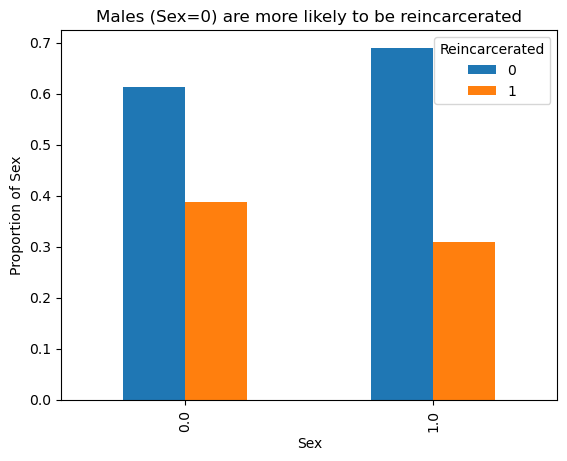

In [36]:
crosstab = pd.crosstab(df['Sex'], df['Reincarcerated'],normalize='index')
ax = crosstab.plot(kind='bar')# stacked=True)
ax.set(ylabel='Proportion of Sex',title='Males (Sex=0) are more likely to be reincarcerated');

#### Race

In [37]:
# Display the disparate impact for Race
print(f"Disparate Impact (Race): {metric_race.disparate_impact()}")
print(explainer_sex.disparate_impact())


Disparate Impact (Race): 1.0561530353156547
Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.1263090220102636


In the case of Race, since the value is greater than 1 (1.05) the dataset is actually biased with non-whites being more likely to be non-recidivists than male.

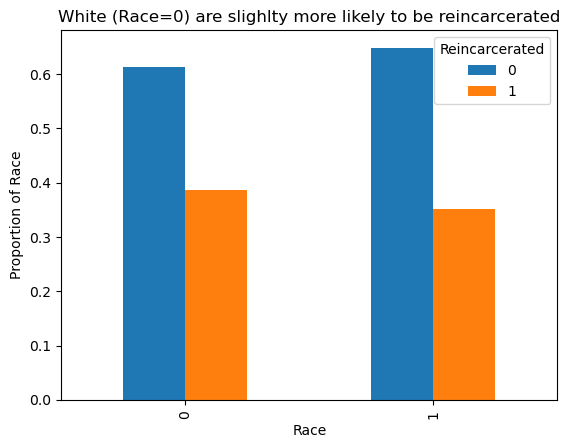

In [38]:
crosstab = pd.crosstab(df['Race'], df['Reincarcerated'],normalize='index')
ax = crosstab.plot(kind='bar')# stacked=True)
ax.set(ylabel='Proportion of Race',title='White (Race=0) are slighlty more likely to be reincarcerated');

### Mean Difference

> The **mean_difference** fairness metric is a measure used to assess the fairness of a machine learning model's predictions across different groups or demographics. It quantifies the average difference in predicted outcomes between different groups.

- In the context of fairness, groups can be defined based on sensitive attributes such as race, gender, or age. 
- The mean_difference metric calculates the average difference in predicted outcomes (e.g., probabilities or scores) between these groups.



To calculate the mean_difference fairness metric, you need to follow these steps:

1. Identify the sensitive attribute or group that you want to evaluate for fairness.
2. Split your dataset into subgroups based on the sensitive attribute.
3. For each subgroup, calculate the average predicted outcome.
4. Calculate the difference between the average predicted outcomes of different subgroups.
5. Take the absolute value of the differences to ensure that negative and positive differences are treated equally.
6, Finally, calculate the average of these absolute differences across all subgroups.

The resulting value represents the mean_difference fairness metric. 

>- A value close to zero indicates that the model's predictions are similar across different groups, suggesting fairness. On the other hand, a larger value indicates a significant difference in predictions between groups, suggesting potential bias or unfairness.


#### Sex

In [39]:
print(f"Mean Difference (Sex): {metric_sex.mean_difference()}")
print(explainer_sex.mean_difference())

Mean Difference (Sex): 0.07741274694382239
Mean difference (mean label value on unprivileged instances - mean label value on privileged instances): 0.07741274694382239


We can calculate this manually to confirm our understanding.

In [40]:
# Calculating the mean difference manually
group_means = df.groupby("Sex")['Reincarcerated'].mean()
group_means

Sex
0.0    0.387116
1.0    0.309704
Name: Reincarcerated, dtype: float64

In [41]:
# Subtract the mean of the unprivileged group from the privileged group
abs(group_means.loc[1.0] - group_means.loc[0.0])

0.07741274694382239

We can see that the mean difference between groups is ~7.7%, which matches the metric class's results.

#### Race

In [42]:
print(f"Mean Difference (Race): {metric_race.mean_difference()}")
print(explainer_race.mean_difference())

Mean Difference (Race): 0.034476031755028
Mean difference (mean label value on unprivileged instances - mean label value on privileged instances): 0.034476031755028


We can see that the mean difference between groups is ~3.4%.

Our dataset is more biased in terms of Sex than it is for Race. 

#### Base Rate

>The **base_rate** metric for fairness is a measure that evaluates the proportion of positive outcomes (e.g., approvals, acceptances, etc.) within a particular group. 
- It is used to compare the rates of favorable outcomes across different groups defined by sensitive attributes such as race, gender, or age.

To calculate the base_rate for a group, follow these steps:

1. Identify the group based on the sensitive attribute.
2. Count the number of positive outcomes (e.g., the number of approved loans) within the group.
3. Divide this count by the total number of instances in the group.

The formula for the base_rate is:

$ \text{Base Rate} = \frac{\text{Number of Positive Outcomes}}{\text{Total Number of Instances in the Group}} $

- The base_rate can then be compared across different groups to assess fairness. If the base_rate is significantly different between groups, it may indicate potential bias or unfairness in the decision-making process.


#### Sex

In [43]:
## Base Rate
# print(explainer_train.base_rate())
priv_base_rate = metric_sex.base_rate()
unprov_base_rate = metric_sex.base_rate(privileged=False)

print("For protected attribute: Sex")
print(f"- Privileged Base Rate: {priv_base_rate}")
print(f"- Unprivileged Base Rate: {unprov_base_rate}")

For protected attribute: Sex
- Privileged Base Rate: 0.6243067659641895
- Unprivileged Base Rate: 0.6902964959568734


In [44]:
## Calculating manually with pandas
value_counts = df.groupby("Sex")['Reincarcerated'].value_counts(normalize=True)
value_counts


Sex  Reincarcerated
0.0  0                 0.612884
     1                 0.387116
1.0  0                 0.690296
     1                 0.309704
Name: proportion, dtype: float64

In [45]:
# Slice the base rate for the privileged group
value_counts.loc[0.0,0]

0.612883749013051

In [46]:
# Slice the base rate for the unprivileged group
value_counts.loc[1.0,0]

0.6902964959568734

We can see that the unprivileged class for Sex is more likely to be a non-recividist (the desirable outcome).

#### Race

In [47]:
## Base Rate
# print(explainer_train.base_rate())
priv_base_rate = metric_race.base_rate()
unprov_base_rate = metric_race.base_rate(privileged=False)

print("For protected attribute: Race")
print(f"- Privileged Base Rate: {priv_base_rate}")
print(f"- Unprivileged Base Rate: {unprov_base_rate}")

For protected attribute: Race
- Privileged Base Rate: 0.6243067659641895
- Unprivileged Base Rate: 0.6484416270470154



The base_rate metric is useful for identifying disparities in outcomes across different groups and is often used in conjunction with other fairness metrics to provide a comprehensive assessment of fairness in machine learning models.


#### Statistical Parity Difference

Statistical parity difference measures the difference in the probability of favorable outcomes between unprivileged and privileged groups.


In [48]:
# Statistical Parity Difference for Sex
print(f"Statistical Parity Difference (Sex): {metric_sex.statistical_parity_difference()}")


Statistical Parity Difference (Sex): 0.07741274694382239


In [49]:
print(f"Statistical Parity Difference (Race): {metric_race.statistical_parity_difference()}")


Statistical Parity Difference (Race): 0.034476031755028


Note that the values are equivalent to the previous mean_difference.


### Conclusion

By following the steps outlined in this post, you will be well-equipped to start using AI Fairness 360 to create fairer AI models. If you have any questions or would like to discuss AI fairness further, feel free to connect with me on LinkedIn or leave a comment below.

I encourage you to experiment with AI Fairness 360 in your projects and contribute to creating fair AI systems. Together, we can make AI work for everyone.

### Further Reading
- IBM AI Fairness 360: [AIF360 Documentation](https://aif360.mybluemix.net/)
- Fairness and Machine Learning by Solon Barocas, Moritz Hardt, and Arvind Narayanan
- Algorithmic Bias Detection and Mitigation: Best Practices and Policies to Reduce Consumer Harms by the Federal Trade Commission



### References
- [Disparate Impact](https://en.wikipedia.org/wiki/Disparate_impact)
- [AI Fairness 360 GitHub Repository](https://github.com/IBM/AIF360)
- [Bias in AI: A Review of Literature](https://arxiv.org/abs/1908.09635)



___

## Glossary for AI Fairness 360 Terms

#### Protected Attributes
**Definition**: Attributes that refer to characteristics of individuals that are legally protected against discrimination. These can include race, gender, age, religion, disability status, and other similar attributes.
**Example**: In a dataset about job applicants, 'race' and 'gender' could be considered protected attributes.

#### Privileged Groups
**Definition**: Subsets of individuals within a dataset that have historically been favored or have had advantages in societal contexts based on certain protected attributes.
**Example**: In the context of gender, males may be considered a privileged group in certain employment datasets.

#### Unprivileged Groups
**Definition**: Subsets of individuals within a dataset that have historically been disadvantaged or have faced discrimination based on certain protected attributes.
**Example**: In the context of race, individuals identifying as Black or Hispanic might be considered unprivileged groups in certain societal contexts.

#### Favorable Label
**Definition**: The outcome or class in a dataset that is considered positive or beneficial for the individual.
**Example**: In a dataset predicting loan approvals, a favorable label would be 'approved' (indicating that the loan application was successful).

#### Unfavorable Label
**Definition**: The outcome or class in a dataset that is considered negative or detrimental for the individual.
**Example**: In a dataset predicting recidivism, an unfavorable label would be 'reoffended' (indicating that the individual reoffended after being released from prison).
